         
            Neg   Pos
  Placebo 19343   348
  Vaccine 19514   116

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Tue Jun 22 13:32:58 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 78651
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.01590610,0.01772255,0.01959080,0.01774012,0.0009373417,NA,4.652299e-06,0.5,40594,-0.005021807,0.9999866
theta[2],0.00498008,0.00601477,0.00713171,0.00602943,0.0005519269,NA,2.759635e-06,0.5,40000,0.003486267,1.0000582
theta[3],58.64650000,66.08450000,72.69520000,65.91725735,3.6084139386,NA,1.797418e-02,0.5,40303,0.001778732,1.0000840


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
           Lower95    Median   Upper95      Mean         SD Mode      MCerr
theta[1]  0.015908  0.017724  0.019597  0.017741 0.00094089   -- 3.3065e-06
theta[2] 0.0049768 0.0060129 0.0071317 0.0060291 0.00055146   -- 1.9536e-06
theta[3]    58.594    66.087    72.695     65.92     3.6063   --    0.01275
                                         
         MC%ofSD SSeff      AC.10    psrf
theta[1]     0.4 80971 -0.0050218 0.99998
theta[2]     0.4 79683  0.0034863       1
theta[3]     0.4 80000  0.0017787       1

Total time taken: 2.2 minutes


,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,66.51452,0.95,58.59394,72.695,1


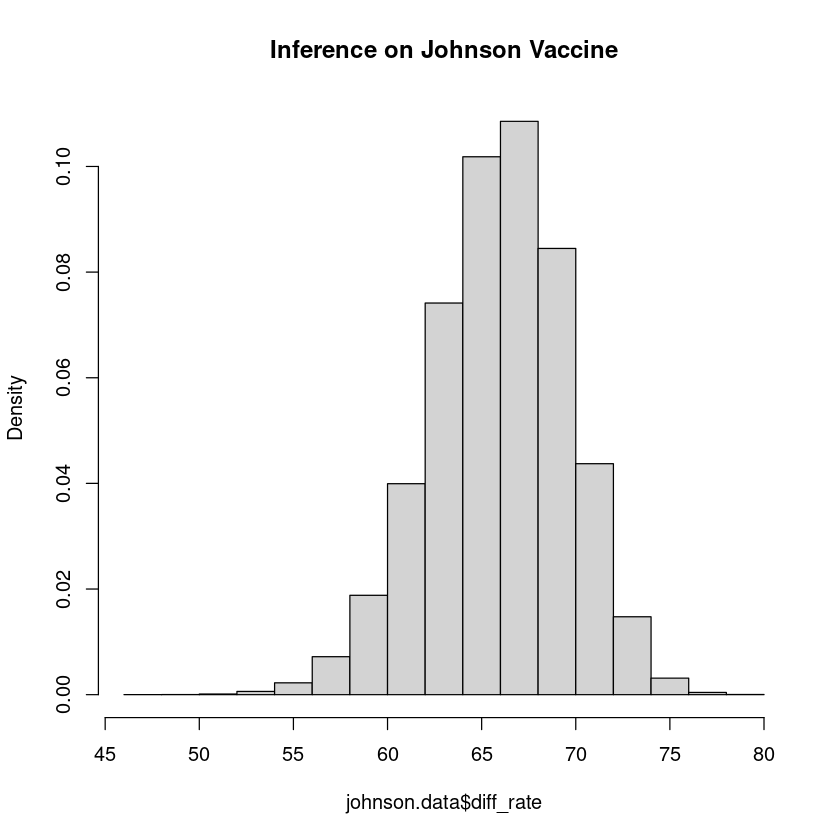

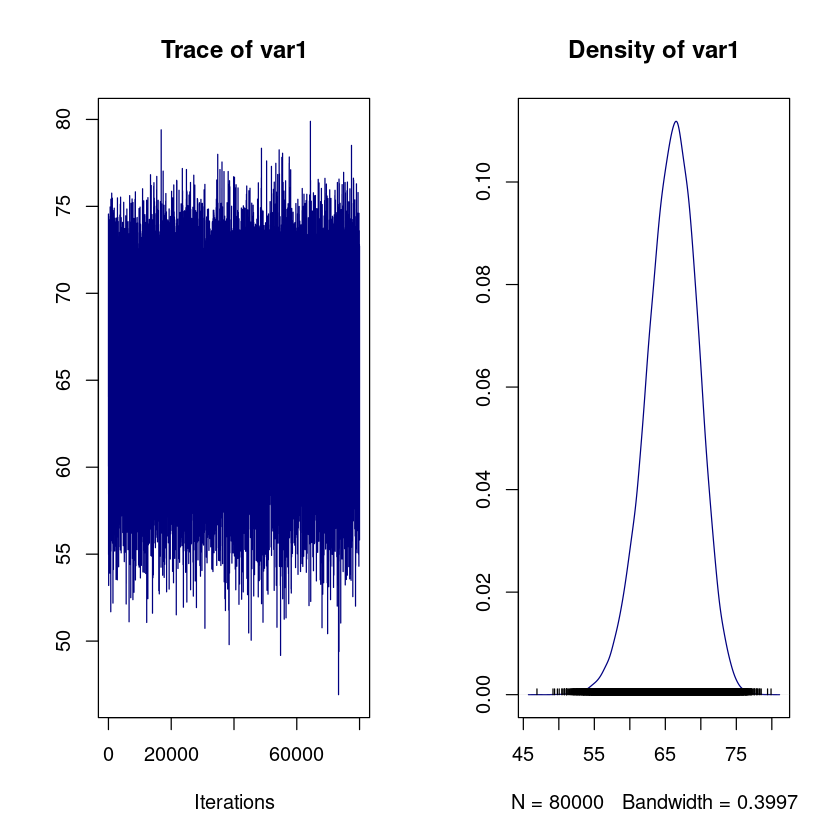

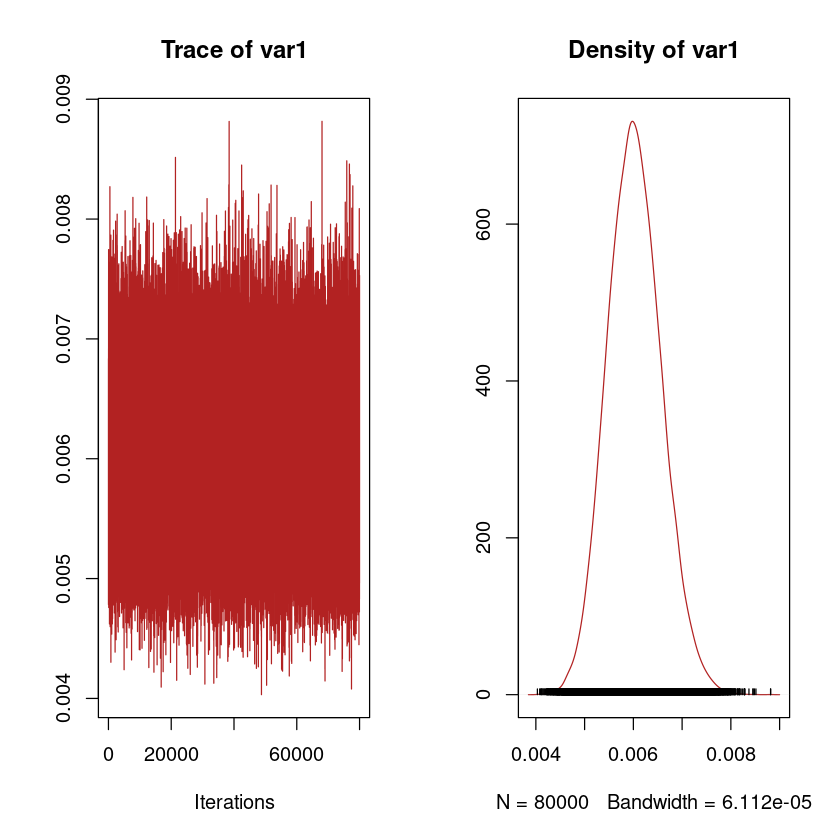

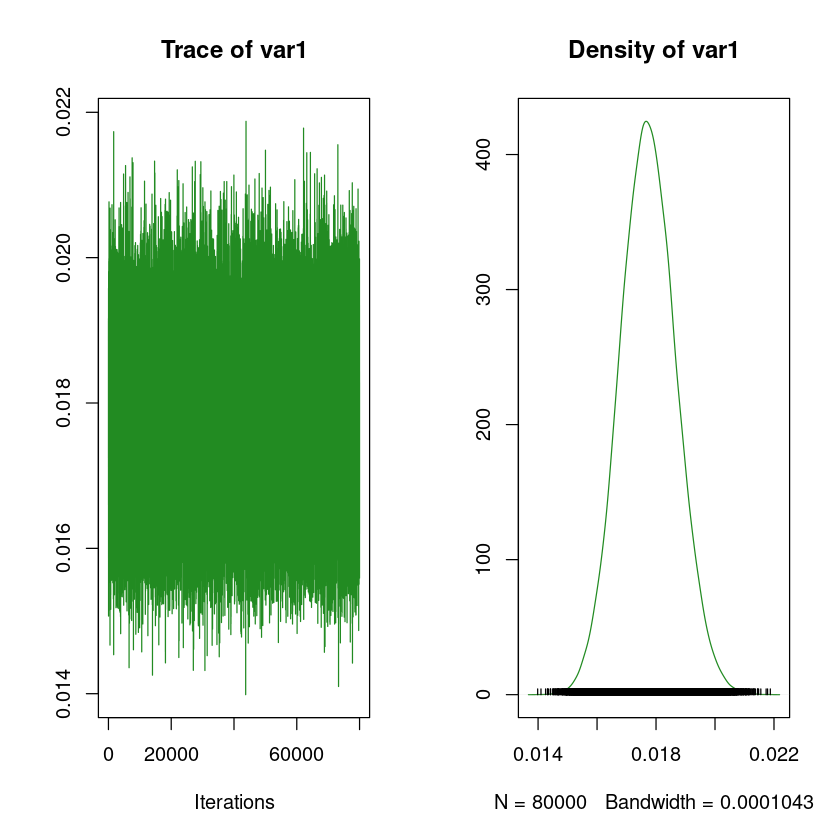

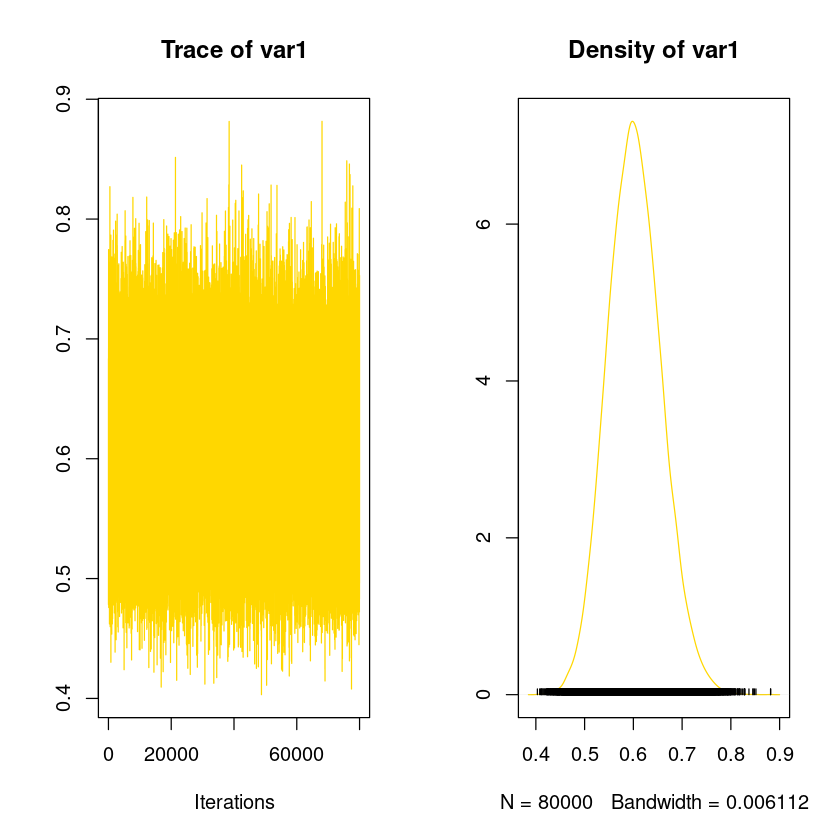

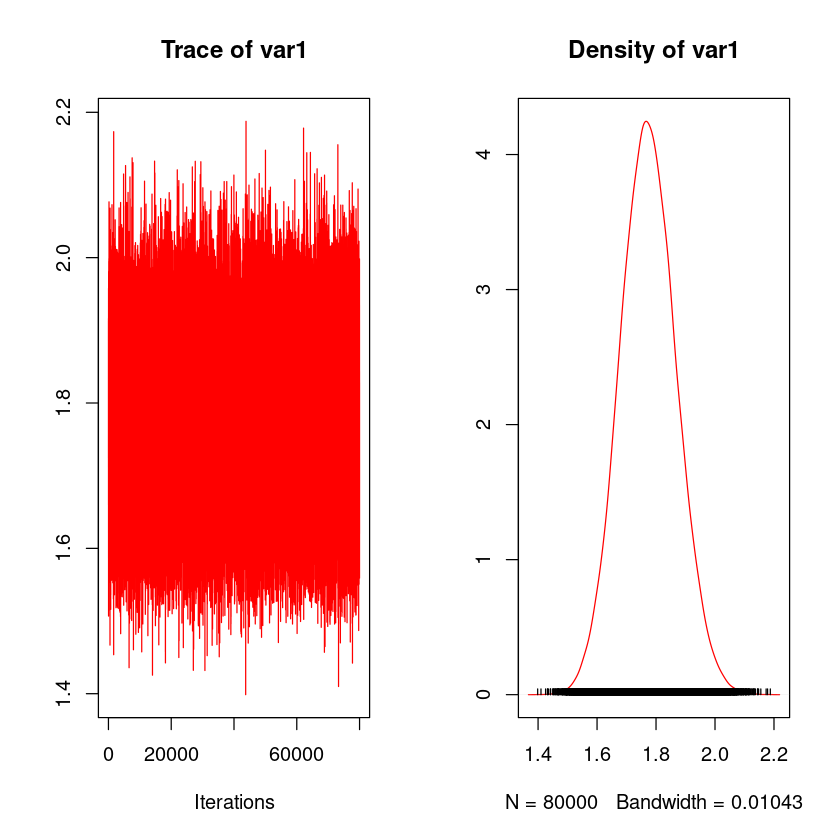

In [2]:
library(rjags)
library(runjags)
library(R2jags)
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)

tot_vaccine <- 19630
tot_placebo <- 19691
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 116
pos_placebo <- 348
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
johnson.tb <- tibble::tibble(tested = tested, patient=patient)
table(johnson.tb[[2]], johnson.tb[[1]])

dataList = list(
    tested = ifelse(johnson.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(johnson.tb$patient)),
    Ntot = nrow(johnson.tb) ,
    Nclass = nlevels(factor(johnson.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Johnson_model.txt")

johnson_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(johnson_chains)
add.summary(johnson_chains)

johnson_res    <- tidybayes::tidy_draws(johnson_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

johnson.mcmc <- as.mcmc(johnson_res)
johnson.data <- as.data.frame(johnson.mcmc)

hist(johnson.data$diff_rate,freq=FALSE,main='Inference on Johnson Vaccine')

bayestestR::describe_posterior(johnson.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

plot(johnson.mcmc[,'diff_rate'],col='navy')
plot(johnson.mcmc[,'Vaccine'],col='firebrick')
plot(johnson.mcmc[,'Placebo'],col='forestgreen')
plot(johnson.mcmc[,'Vaccine_perc'],col='gold')
plot(johnson.mcmc[,'Placebo_perc'],col='red')